In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import astropy.io.fits as pyfits
from astropy.stats import sigma_clipped_stats, SigmaClip
from astropy.stats import biweight_location
from astropy.stats import mad_std
from astropy.nddata import NDData
from astropy.table import Table
from astropy.visualization import SqrtStretch
from astropy.visualization import simple_norm
from astropy.visualization.mpl_normalize import ImageNormalize
from photutils.segmentation import detect_threshold, detect_sources
from photutils.psf import EPSFBuilder
from photutils.psf import extract_stars
from photutils.detection import find_peaks

In [28]:
# path = '/Users/connorauge/Research/BASS/galfit/'
# target = 'ESO323-77/'
# filt = 'F225W/ieag46010/ieag46010_drc.fits'

path = '/Users/connorauge/Research/BASS/galfit/'
target = 'UGC3478/'
filt = 'F814W/hst_15444_51_acs_wfc_f814w_jdrw51/hst_15444_51_acs_wfc_f814w_jdrw51_drc.fits'

fsci = pyfits.open(path+target+filt)
fov = fsci[1].data 
norm = ImageNormalize(stretch=SqrtStretch())

mean, median, std = sigma_clipped_stats(fov, sigma=3)
peaks = find_peaks(fov,threshold=2)
print(mean,median,std)

0.05629125 0.05554074 0.014729589


In [29]:
x_peaks = np.asarray(peaks['x_peak'])
y_peaks = np.asarray(peaks['y_peak'])
peak_value = np.asarray(peaks['peak_value'])
print(np.shape(x_peaks),np.shape(y_peaks),np.shape(peak_value))

(1055,) (1055,) (1055,)


In [31]:
# psf_use = [351,2367,2740,1497,1688,2191,3066] # UGC3478 - F435W
# psf_use = [1041,3950,2783,1354,2340,1632,349] # UGC3478 - F814W
psf_use = [3342, 3262, 1726, 1283]
# psf_use = [1361,1136,2189,560,989,249] # LEDA75258
# psf_use = [1450,3135,2866,1160] # ESO323-77 F225W
x_peaks2, y_peaks2, peak_value2 = [], [], []

for i in range(len(psf_use)):
    x_peaks2.append(peaks['x_peak'][peaks['x_peak'] == psf_use[i]])
    y_peaks2.append(peaks['y_peak'][peaks['x_peak'] == psf_use[i]])
    peak_value2.append(peaks['peak_value'][peaks['x_peak'] == psf_use[i]])

x_peaks2, y_peaks2, peak_value2 = np.asarray(x_peaks2), np.asarray(y_peaks2), np.asarray(peak_value2)


[<Column name='x_peak' dtype='int64' length=1>
3342, <Column name='x_peak' dtype='int64' length=1>
3262, <Column name='x_peak' dtype='int64' length=1>
1726, <Column name='x_peak' dtype='int64' length=1>
1283]


In [32]:
peaks_array = np.asarray([x_peaks,y_peaks,peak_value]).T
peaks_array = np.array([x_peaks2,y_peaks2,peak_value2]).T[0]

print(peaks_array)


[[3.34200000e+03 1.16200000e+03 2.37204494e+01]
 [3.26200000e+03 1.37600000e+03 4.96356812e+01]
 [1.72600000e+03 1.84300000e+03 1.80669670e+01]
 [1.28300000e+03 2.18500000e+03 2.00162768e+00]]


In [33]:
peaks_t = Table(peaks_array,names=('x','y','peak'))
fov_ndda = NDData(fov)
stars = extract_stars(data = fov_ndda,catalogs = peaks_t,size=(111,111))
print(stars.center_flat)
print(stars.n_good_stars)


[[3342. 1162.]
 [3262. 1376.]
 [1726. 1843.]
 [1283. 2185.]]
4


0 [3342. 1162.]


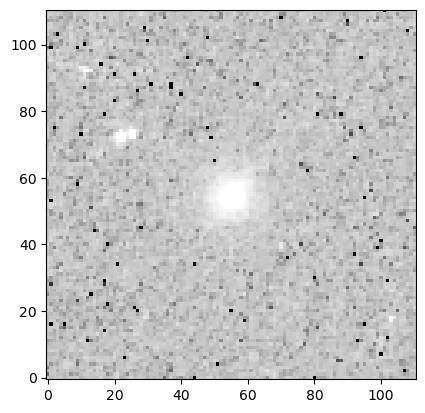

1 [3262. 1376.]


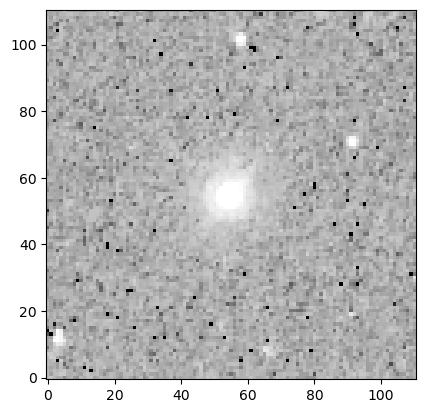

2 [1726. 1843.]


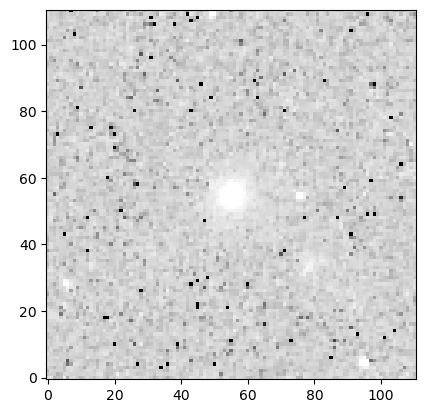

3 [1283. 2185.]


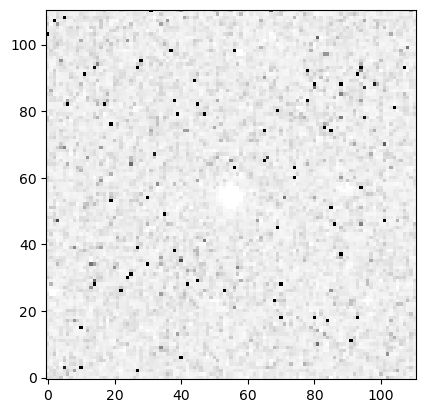

In [34]:
for i in range(stars.n_good_stars):
    print(i,stars.center_flat[i])
    norm = simple_norm(stars[i],'log',percent=99.)
    plt.imshow(stars[i],norm=norm,origin='lower',cmap='Greys_r',interpolation='nearest')
    plt.show()

In [35]:
epsf_builder = EPSFBuilder(oversampling=1)
ePSF, fitted_stars = epsf_builder(stars)

EPSFBuilder (10 maxiters):   0%|          | 0/10 [00:00<?, ?it/s]

Model: EPSFModel
Inputs: ('x', 'y')
Outputs: ('z',)
Model set size: 1
Parameters:
    flux x_0 y_0
    ---- --- ---
     1.0 0.0 0.0
here
<class 'photutils.psf.models.EPSFModel'>
Name: EPSFModel (FittableImageModel)
N_inputs: 2
N_outputs: 1
Fittable parameters: ('flux', 'x_0', 'y_0')


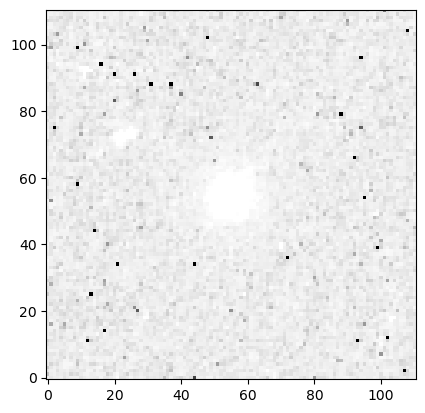

In [36]:
print(ePSF)
print('here')
print(type(ePSF))

print(fitted_stars)
plt.imshow(fitted_stars[0],norm=norm,origin='lower',cmap='Greys_r',interpolation='nearest')
plt.show()

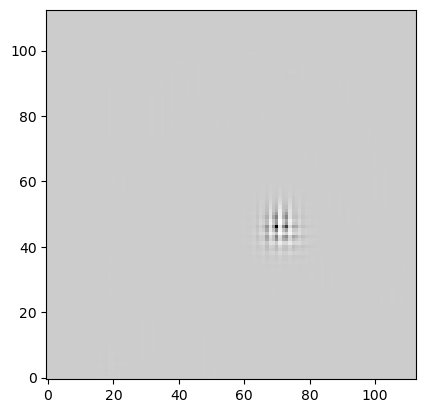

In [37]:
norm = ImageNormalize(stretch=SqrtStretch())
# norm = simple_norm(ePSF.data,'log',percent=99.)
# norm = LogNorm(vmin=0.001, vmax=1)
plt.imshow(ePSF.data,norm=norm,origin='lower',cmap='Greys_r',interpolation='nearest')
plt.show()

In [38]:
pyfits.writeto(f'{path}{target}F814W/hst_15444_51_acs_wfc_f814w_jdrw51/UGC3478_F814W_679_PSF.fits',ePSF.data,overwrite=True)

In [39]:
ftot = 2.287E-15
mtot = -2.5*np.log10(ftot)-21.0009
print(mtot)

15.600934588483128


In [41]:
fbkg = 1.317E-15
mbkg = -2.5*np.log10(fbkg)-21.0009
print(mbkg)

16.200135562595534


In [45]:
DN = 137.3871876-9
mbkg = -2.5*np.log10(DN*4.6321736E-18)-21.0009
print(mbkg)


17.06333371860785


In [43]:
137.3871876*46321736E-18

6.364013033789674e-09

In [46]:
-2.5*np.log10(4.6321736E-18) - 21.10


22.235537932296275

In [47]:
ZPab = -2.5*np.log10(4.6321736E-18)-5*np.log10(2365.22155)-2.408

In [48]:
ZPab

24.05817879585743

In [49]:
-2.5*np.log10(DN*4.6321736E-18)-5*np.log10(2365.22155)-2.408

18.786874582169006